In [1]:
import os, sys
import pandas as pd
import numpy as np

#Plot settings
from coffea import hist
from coffea.processor import defaultdict_accumulator

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#Just to efficiently save plots
plot_dir = "/u/gu/dhoang/ldmx_plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")

save_path = plot_dir + dt_string
print("Saving plot to: ", save_path)

# 2D trigger simulation
def find_pt_indx(pt, pt_edges):
    
    if pt >= pt_edges[-1]:
        pt_indx = -1
    elif pt <= pt_edges[0]:
        pt_indx = 0
    else:
        pt_indx = np.argmax((pt >= pt_edges[:-1]) & (pt <= pt_edges[1:]))
    
    return pt_indx

def find_e_indx(E, e_edges):
    
    if E >= e_edges[-1]:
        e_indx = -1
    elif E <= e_edges[0]:
        e_indx = 0
    else:
        e_indx = np.argmax((E >= e_edges[:-1]) & (E <= e_edges[1:]))
    
    return e_indx

def trigger_weight_2D(pt, E, mode = 'loose'):
    
    if mode == 'loose':
        trigger_weight = np.load("loose_trigger.npy")
    else:
        trigger_weight = np.load("tight_trigger.npy")
        
    
    pt_edges = np.asarray([0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0])/1000.
    e_edges = np.asarray([0.0, 400.0, 800.0, 1200.0, 1600.0, 2000.0, 2400.0, 2800.0, 3200.0, 3600.0, 4000.0])/1000.
    
    #Find the index
    pt_indx = None
    e_indx = None
    
    pt_indx = find_pt_indx(pt, pt_edges)
    e_indx = find_e_indx(E, e_edges)
    
    if np.isnan(trigger_weight[pt_indx, e_indx]):
        return 0.
    else:
        return float(trigger_weight[pt_indx, e_indx]) 

Saving plot to:  /u/gu/dhoang/ldmx_plot/03-04-2021


## 2. Processor

In [2]:
hists = {}

hists["Q_squared"] = hist.Hist("Events", hist.Cat("sample", "Sample name"),
                               hist.Bin("q2", r"$Q^2$ [$GeV^2$]", np.logspace(-2, 1, 20)))

hists["omega"] = hist.Hist("Events", hist.Cat("sample", "Sample name"),
                          hist.Bin("omega", "$\omega$ [GeV]",np.logspace(-1, 1, 20)))

In [3]:
def processor(file_name, config_mode = 'loose'):
    
    gst_df = pd.read_hdf(file_name, key="gst_df")

    query='index' #all
    df=gst_df.query(query)
    
    #Varibale parameters
    wght="MFP_pi"
    sigma=1
    units="GeV/c"
    Eb = 4.0
     
    #--------------------LEADING LEPTONS
    #1D trigger simulation
    trigger_weights = df.apply(lambda x: trigger_weight_2D(x.ptl, x.El, mode = config_mode), axis = 1)
    
    CV_weight = (df["wght"]*trigger_weights).to_numpy()
    plus_sigma_weight = (df["wght_%s_p%d"%(wght,sigma)]*trigger_weights).to_numpy()
    minus_sigma_weight =  (df["wght_%s_n%d"%(wght,sigma)]*trigger_weights).to_numpy()
    
    lepton_e = df['El'].to_numpy()
    lepton_pt = df['ptl'].to_numpy()
    
    omega = Eb - lepton_e #GeV
    Q2 = 2*Eb*(Eb-omega)*(1-np.cos(np.arcsin(lepton_pt/(Eb-omega))))
    
    #omega
    hists["omega"].fill(sample = 'CV', omega = omega, weight = CV_weight)
    hists["omega"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), omega = omega,
                            weight= plus_sigma_weight)
    hists["omega"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), omega = omega,
                            weight= minus_sigma_weight)
    
    #Q^2
    hists["Q_squared"].fill(sample = 'CV', q2 = Q2, weight = CV_weight)
    hists["Q_squared"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), q2 = Q2,
                            weight= plus_sigma_weight)
    hists["Q_squared"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), q2 = Q2,
                            weight= minus_sigma_weight)

    
    %reset -f in

## 1. Loose configuration

In [4]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path)
        
        chunk += 1
#        if chunk == 1:
#            break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


/u/gu/dhoang/ldmx_plot/03-04-2021omega_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


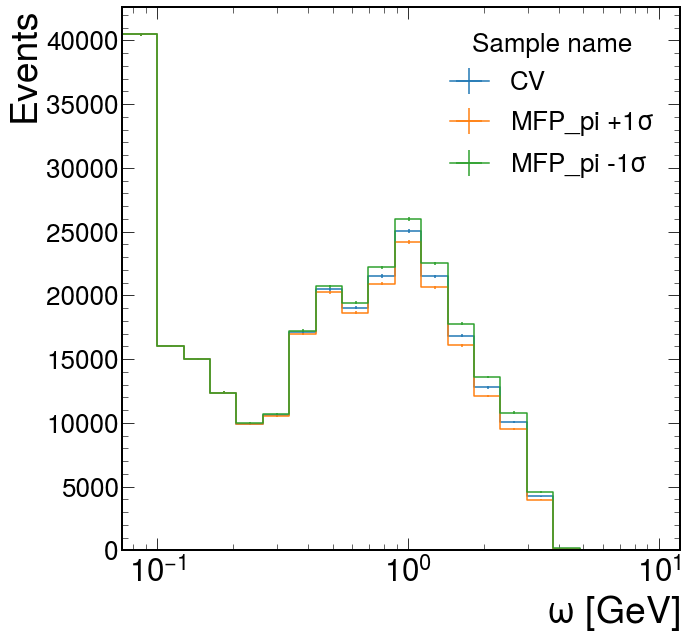

In [7]:
hist.plot1d(hists["omega"], overflow = 'all')
plt.xscale('log')
print(save_path + "omega_loose_trigger.pdf")
plt.savefig(save_path + "omega_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/03-04-2021Q2_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


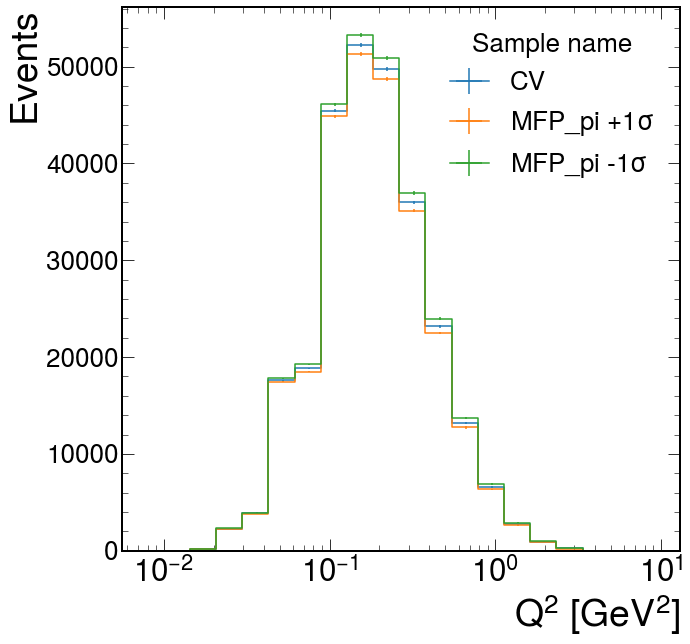

In [8]:
hist.plot1d(hists["Q_squared"], overflow = 'all')
plt.xscale('log')
print(save_path + "Q2_loose_trigger.pdf")
plt.savefig(save_path + "Q2_loose_trigger.pdf", bbox_inches = 'tight')

## 2. Tight configuration

In [4]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path, config_mode = 'tight')
        
        chunk += 1
#        if chunk == 1:
#            break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


/u/gu/dhoang/ldmx_plot/03-04-2021omega_tight_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


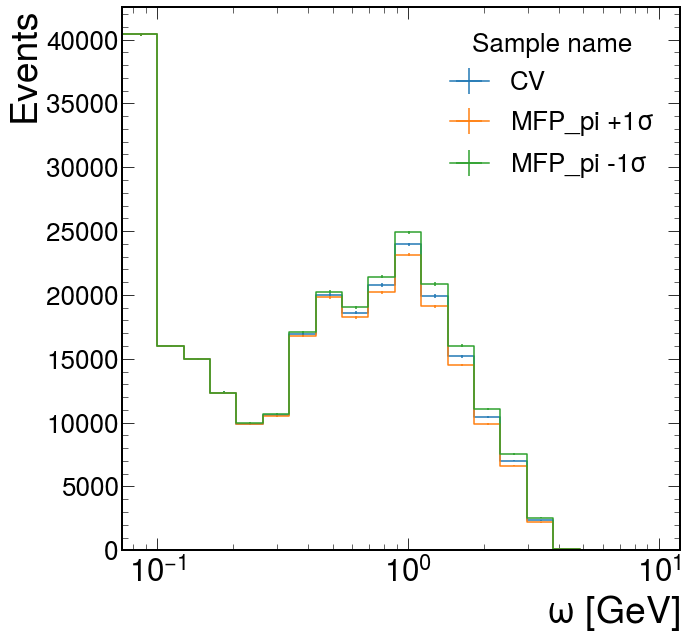

In [5]:
hist.plot1d(hists["omega"], overflow = 'all')
plt.xscale('log')
print(save_path + "omega_tight_trigger.pdf")
plt.savefig(save_path + "omega_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/03-04-2021Q2_tight_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


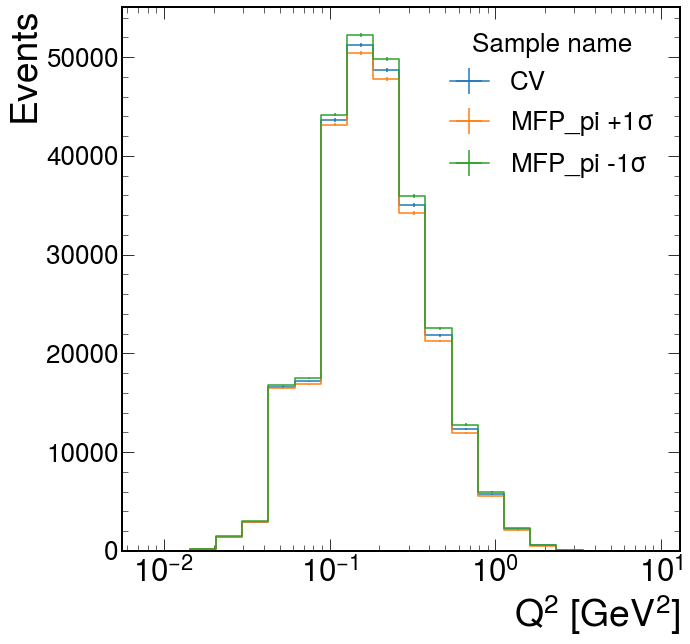

In [6]:
hist.plot1d(hists["Q_squared"], overflow = 'all')
plt.xscale('log')
print(save_path + "Q2_tight_trigger.pdf")
plt.savefig(save_path + "Q2_tight_trigger.pdf", bbox_inches = 'tight')